### Visualise data

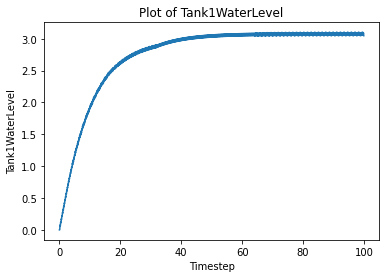

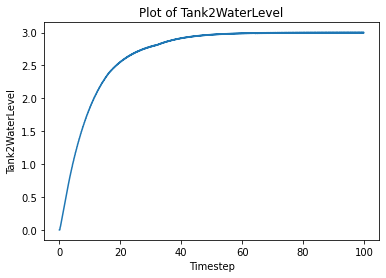

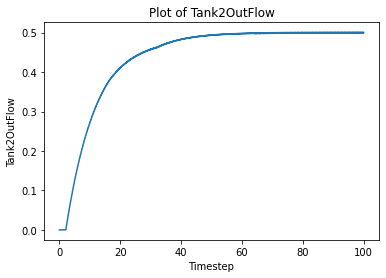

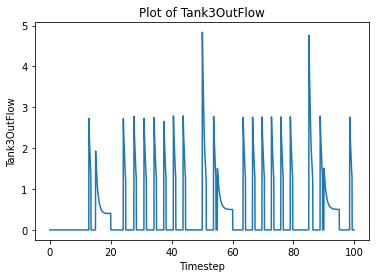

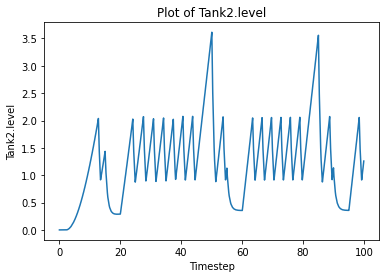

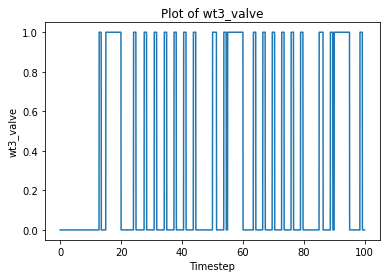

In [21]:
from pandas import read_csv
import matplotlib.pyplot as plt
# mydata = read_csv('waterTankNew.csv', header=0, index_col=0)
mydata = read_csv('waterTank_stuckAt.csv', header=0, index_col=0)
# attr = ["wt3_valve", "Tank1InFlow", "Tank1WaterLevel", "Tank3OutFlow", "Tank2.level"]
attr = ["Tank1WaterLevel", "Tank2WaterLevel", "Tank2OutFlow", "Tank3OutFlow", "Tank2.level", "wt3_valve"]
for i in range(len(attr)):
    title = "Plot of "+str(attr[i])
    actual = mydata.iloc[:2000,i]
#     actual = mydata.iloc[750:1000,i]
    plt.title(title)
    plt.xlabel("Timestep")
    plt.ylabel(attr[i])
#     plt.plot(actual, label="original")
    plt.plot(actual)
#     plt.legend()
    plt.show()

Epoch 1/100
371/371 - 16s - loss: 0.0832 - 16s/epoch - 43ms/step
Epoch 2/100
371/371 - 14s - loss: 0.0369 - 14s/epoch - 37ms/step
Epoch 3/100
371/371 - 14s - loss: 0.0260 - 14s/epoch - 38ms/step
Epoch 4/100
371/371 - 14s - loss: 0.0143 - 14s/epoch - 37ms/step
Epoch 5/100
371/371 - 14s - loss: 0.0116 - 14s/epoch - 37ms/step
Epoch 6/100
371/371 - 14s - loss: 0.0106 - 14s/epoch - 38ms/step
Epoch 7/100
371/371 - 14s - loss: 33190227968.0000 - 14s/epoch - 39ms/step
Epoch 8/100
371/371 - 14s - loss: 0.0162 - 14s/epoch - 38ms/step
Epoch 9/100
371/371 - 14s - loss: 0.0132 - 14s/epoch - 38ms/step
Epoch 10/100
371/371 - 14s - loss: 0.0121 - 14s/epoch - 38ms/step
Epoch 11/100
371/371 - 14s - loss: 0.0168 - 14s/epoch - 38ms/step
Epoch 12/100
371/371 - 14s - loss: 0.0116 - 14s/epoch - 38ms/step
Epoch 13/100
371/371 - 14s - loss: 438.1790 - 14s/epoch - 39ms/step
Epoch 14/100
371/371 - 14s - loss: 0.0731 - 14s/epoch - 38ms/step
Epoch 15/100
371/371 - 14s - loss: 0.0655 - 14s/epoch - 38ms/step
Epoch 1

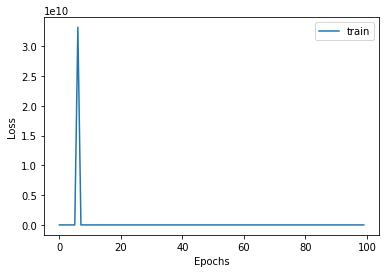

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 20)                2160      
                                                                 
 repeat_vector_6 (RepeatVect  (None, 50, 20)           0         
 or)                                                             
                                                                 
 lstm_13 (LSTM)              (None, 50, 20)            3280      
                                                                 
 time_distributed_6 (TimeDis  (None, 50, 6)            126       
 tributed)                                                       
                                                                 
Total params: 5,566
Trainable params: 5,566
Non-trainable params: 0
_________________________________________________________________
Model saved!


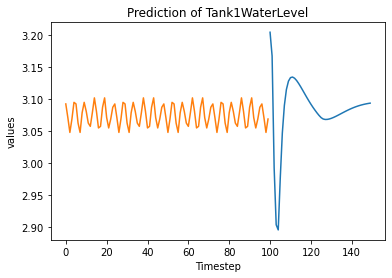

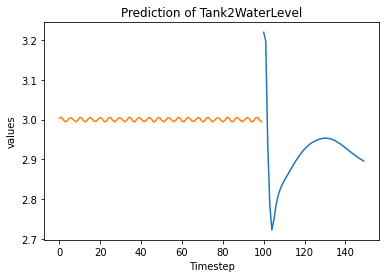

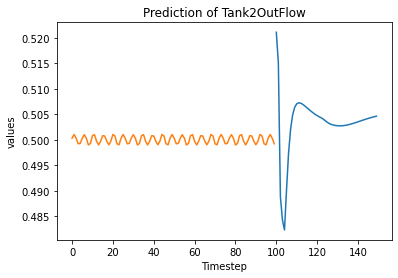

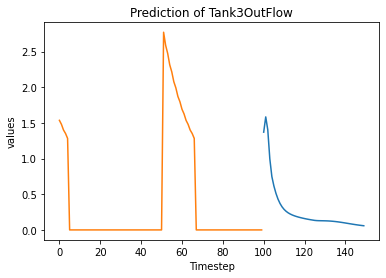

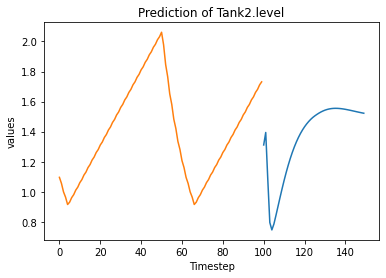

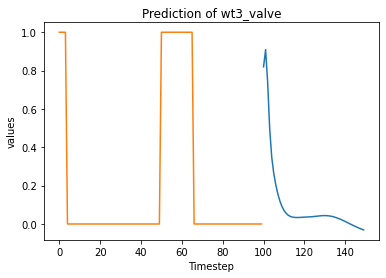

In [22]:
# multivariate output stacked lstm example
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed

# Load and preprocess data
data = pd.read_csv('waterTank_stuckAt.csv', header=0, index_col=0)
raw_data = data.values
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(raw_data)

# Split data into train and test sets
# train_size = int(len(data) * 0.7)
train_size = 12000
test_size = len(data) - train_size
train, test = data_scaled[0:train_size,:], data_scaled[train_size:len(data),:]

# Define the number of time steps and features
n_steps_in = 100
n_steps_out = 50
n_features = data.shape[1]

# Reshape data for LSTM
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = [], []
    for i in range(len(sequence)):
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out - 1
        if out_end_ix > len(sequence)-1:
            break
        seq_x, seq_y = sequence[i:end_ix, :], sequence[end_ix-1:out_end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

X_train, y_train = split_sequence(train, n_steps_in, n_steps_out)
X_test, y_test = split_sequence(test, n_steps_in, n_steps_out)

# Define the LSTM model
model = Sequential()
model.add(LSTM(20, activation='relu', input_shape=(n_steps_in, n_features)))
model.add(RepeatVector(n_steps_out))
model.add(LSTM(20, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(n_features)))

# Compile and fit the model
model.compile(optimizer='adam', loss='mse')
train_history = model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=2)

# Evaluate the model
mse = model.evaluate(X_test, y_test, verbose=0)
print('Mean Squared Error:', mse)

# Get the last n_steps_in time steps of the original data
x_original = data_scaled[-n_steps_in:, :]

# Reshape predictions for inverse scaling
x_original = x_original.reshape((1, n_steps_in, n_features))

# Make predictions on test data
y_pred = model.predict(x_original)

# Get the forecast values into the future
forecast = scaler.inverse_transform(y_pred[0, :, :])
# forecast = y_pred[0, :, :]

# print(forecast)

print("-------Learning Curve--------")
plt.plot(train_history.history['loss'], label='train')
# plt.plot(train_history.history['val_loss'], label='test')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

model.summary()

#save the model to disk
model.save('stuckat_wt3.h5')
print("Model saved!")

# View results
attr = ["Tank1WaterLevel", "Tank2WaterLevel", "Tank2OutFlow", "Tank3OutFlow", "Tank2.level", "wt3_valve"]
for i in range(len(attr)):
    title = "Prediction of "+str(attr[i])
    actual = raw_data[train_size - n_steps_in:train_size,i]
#     actual = raw_data[11901:12000,i]
#     pred = inv_yhat.T
    pred_df = pd.DataFrame(forecast)
    # specify the range based on the length of predicted output
#     index = pd.Index(list(range(n_steps_in,n_steps_in + n_steps_out)))
    index = pd.Index(list(range(n_steps_in, n_steps_in + n_steps_out)))
    pred_df = pred_df.set_index(index)
    plt.title(title)
    plt.xlabel("Timestep")
    plt.ylabel("values")
#     plt.plot(pred[i], label="predicted")
#     plt.plot(actual, label="actual")
    plt.plot(pred_df[i], label="predicted")
    plt.plot(actual, label="actual")
    plt.show()

In [15]:
pred_df.shape

(100, 6)

### Load the pretrained surrogate model

In [26]:
from keras.models import load_model

s_model = load_model('stuckat_wt3.h5')

new_data = data_scaled[12000:14000,:]

# choose a number of time steps
n_steps_in, n_steps_out = 50, 100

# convert into input/output
test_X, test_y = split_sequence(new_data, n_steps_in, n_steps_out)
# the dataset knows the number of features, e.g. 2
n_features = test_X.shape[2]

score = s_model.evaluate(test_X, test_y, verbose=0)
# test_yhat = s_model.predict(test_X, verbose=0)
print("%s:  %.2f%%" % (s_model.metrics_names[0], score*100))


print("Prediction is successful!")

ValueError: in user code:

    File "C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1525, in test_function  *
        return step_function(self, iterator)
    File "C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1514, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1507, in run_step  **
        outputs = model.test_step(data)
    File "C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1471, in test_step
        y_pred = self(x, training=False)
    File "C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "sequential_6" is incompatible with the layer: expected shape=(None, 100, 6), found shape=(None, 50, 6)
